In [0]:
from __future__ import absolute_import,division,print_function,unicode_literals
import tensorflow as tf
from tensorflow import keras
import IPython.display as display

import matplotlib as mpl
import matplotlib.pyplot as plt
import time
import functools
import numpy as np

In [0]:
mpl.rcParams["figure.figsize"]=(12,12)
mpl.rcParams["axes.grid"]=False

In [0]:
content_path = keras.utils.get_file('turtle.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/Green_Sea_Turtle_grazing_seagrass.jpg')
style_path = keras.utils.get_file('kandinsky.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg')

In [0]:
def load_image(path):
  max_dim=512
  image=tf.io.read_file(path)
  image=tf.image.decode_image(image)
  image=tf.image.convert_image_dtype(image,tf.float32)

  shape=tf.cast(image.shape[:-1],tf.float32)
  long_dim=max(shape)
  scale=max_dim/long_dim
  new_shape=tf.cast(shape*scale,tf.int32)

  image=tf.image.resize(image,new_shape)
  image=image[tf.newaxis,:]
  return image

(-0.5, 511.5, 335.5, -0.5)

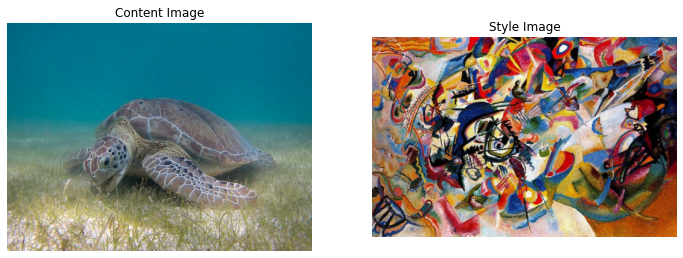

In [61]:
content_image=load_image(content_path)
style_image=load_image(style_path)

plt.subplot(1,2,1)
plt.imshow(tf.squeeze(content_image))
plt.title("content image".title())
plt.axis("off")
plt.subplot(1,2,2)
plt.imshow(tf.squeeze(style_image))
plt.title("style image".title())
plt.axis("off")

In [62]:
x=keras.applications.vgg19.preprocess_input(content_image * 255)
x=tf.image.resize(x,(224,224))
vgg19=keras.applications.VGG19(include_top=True,weights="imagenet")

prediction=vgg19(x)
prediction.shape

TensorShape([1, 1000])

In [63]:
prediction_top5=keras.applications.vgg19.decode_predictions(prediction.numpy())[0]
[(class_name, prob) for (number, class_name, prob) in prediction_top5]

[('loggerhead', 0.742976),
 ('leatherback_turtle', 0.11357888),
 ('hermit_crab', 0.054412704),
 ('terrapin', 0.03923557),
 ('mud_turtle', 0.012614725)]

In [64]:
vgg19=keras.applications.VGG19(include_top=False,weights="imagenet")
vgg19.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

In [0]:
# 内容层将提取出我们的 feature maps （特征图）
content_layers = ['block5_conv2'] 

# 我们感兴趣的风格层
style_layers = ['block1_conv1',
         'block2_conv1',
         'block3_conv1', 
         'block4_conv1', 
         'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [0]:
def vgg_layers(layer_names):
  vgg=tf.keras.applications.VGG19(include_top=False,weights="imagenet")
  vgg.trainable=False

  outputs=[vgg.get_layer(name).output for name in layer_names]

  model=tf.keras.Model([vgg.input],outputs) #由vgg.input决定了所有
  return model

In [0]:
style_extractor=vgg_layers(style_layers)
style_outputs=style_extractor(style_image * 255)

In [68]:
style_extractor.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0   

In [0]:
def gram_matrix(input_tensor):
  result=tf.linalg.einsum("bigc,bijd->bcd",input_tensor,input_tensor)
  input_shape=tf.shape(input_tensor)
  num_locations=tf.cast(input_shape[1]*input_shape[2],tf.float32)
  return result/num_locations

In [0]:
class StyleContentModel(keras.models.Model):
  def __init__(self,style_layers,content_layers):
    super(StyleContentModel,self).__init__()
    self.vgg=vgg_layers(style_layers+content_layers)
    self.style_layers=style_layers
    self.content_layers=content_layers
    self.num_style_layers=len(style_layers)
    self.vgg.trainable=False
  
  def call(self,inputs):
    inputs=inputs*255
    preprocessed_input=keras.applications.vgg19.preprocess_input(inputs)
    outputs=self.vgg(preprocessed_input)
    style_outputs,content_outputs=(outputs[:self.num_style_layers],
                    outputs[self.num_style_layers:])
    style_outputs=[gram_matrix(style_output) for style_output in style_outputs]

    content_dict={content_name:value for content_name,value in zip(self.content_layers,content_outputs)}
    style_dict={style_name:value for style_name,value in zip(self.style_layers,style_outputs)}

    return {"content":content_dict,"style":style_dict}
    

In [71]:
extractor=StyleContentModel(style_layers,content_layers)
results=extractor(tf.constant(content_image))

print('Styles:')
for name, output in sorted(results['style'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())
  print()

print("Contents:")
for name, output in sorted(results['content'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())

Styles:
   block1_conv1
    shape:  (1, 64, 64)
    min:  2973.0647
    max:  13106852.0
    mean:  377045.06

   block2_conv1
    shape:  (1, 128, 128)
    min:  7.652984
    max:  23390078.0
    mean:  2758335.2

   block3_conv1
    shape:  (1, 256, 256)
    min:  848.5838
    max:  23050318.0
    mean:  814901.7

   block4_conv1
    shape:  (1, 512, 512)
    min:  429.6075
    max:  170229200.0
    mean:  6175360.0

   block5_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  984690.06
    mean:  18037.219

Contents:
   block5_conv2
    shape:  (1, 24, 32, 512)
    min:  0.0
    max:  939.078
    mean:  8.983593


In [0]:
style_targets=extractor(style_image)["style"]
content_targets=extractor(content_image)["content"]

In [0]:
def clip_0_1(image):
  return tf.clip_by_value(image,clip_value_min=0,clip_value_max=1)

In [0]:
optimizer=tf.optimizers.Adam(learning_rate=0.02,beta_1=0.99,epsilon=1e-1)

In [0]:
style_weight=1e4
content_weight=1e-1

In [0]:
def style_content_loss(outputs):
  style_outputs=outputs["style"]
  content_outputs=outputs["content"]
  style_loss=tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name]) ** 2) for name in style_outputs.keys()])
  content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name]) **2 ) for name in content_outputs.keys()])
  content_loss *= content_weight / num_content_layers
  loss = style_loss + content_loss
  return loss


In [0]:
image=tf.Variable(content_image)

In [0]:
@tf.function
def train_step(image):
  with tf.GradientTape() as tape:
    outputs=extractor(image)
    loss=style_content_loss(outputs)
  
  grad=tape.gradient(loss,image)
  optimizer.apply_gradients([(grad,image)])
  image.assign(clip_0_1(image))

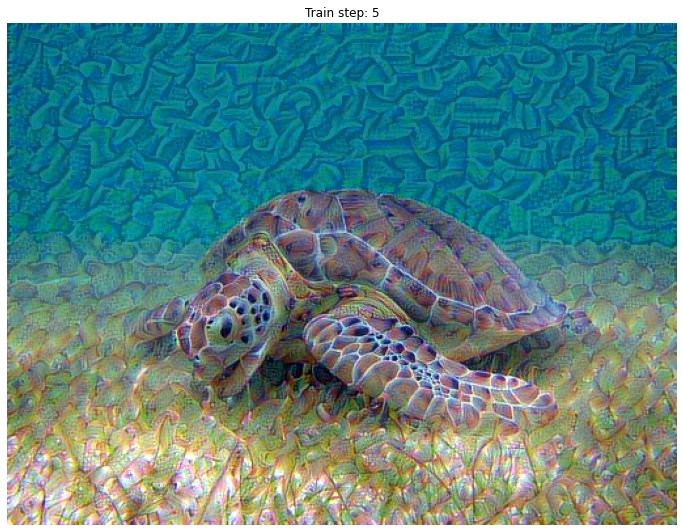


Total time: 32.0


In [79]:
import time
from tqdm.notebook import trange
start = time.time()

epochs = 5
steps_per_epoch = 1

step = 0
for n in trange(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='')
  display.clear_output(wait=True)
  plt.imshow(image.read_value()[0])
  plt.axis("off")
  plt.title("Train step: {}".format(step))
  plt.show()

end = time.time()
print("Total time: {:.1f}".format(end-start))

In [0]:
|